## Import the Packages

In [0]:
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, Input
from keras.models import Sequential, load_model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Data Loading

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil -m cp gs://deep-nexus/Kather_texture/hdf5_data/train.hdf5 sample_data/

Copying gs://deep-nexus/Kather_texture/hdf5_data/train.hdf5...
\ [1/1 files][257.5 MiB/257.5 MiB] 100% Done                                    
Operation completed over 1 objects/257.5 MiB.                                    


In [0]:
!gsutil -m cp gs://deep-nexus/Kather_texture/hdf5_data/test.hdf5 sample_data/

Copying gs://deep-nexus/Kather_texture/hdf5_data/test.hdf5...
\ [1/1 files][ 32.5 MiB/ 32.5 MiB] 100% Done                                    
Operation completed over 1 objects/32.5 MiB.                                     


In [0]:
!gsutil -m cp gs://deep-nexus/Kather_texture/hdf5_data/valid.hdf5 sample_data/

Copying gs://deep-nexus/Kather_texture/hdf5_data/valid.hdf5...
\ [1/1 files][ 31.9 MiB/ 31.9 MiB] 100% Done                                    
Operation completed over 1 objects/31.9 MiB.                                     


In [0]:
def load_dataset():
    train_dataset = h5py.File('sample_data/train.hdf5', "r")
    X_train = np.array(train_dataset["data_x"][:]) # your train set features
    y_train = np.array(train_dataset["data_y"][:]) # your train set labels

    valid_dataset = h5py.File('sample_data/valid.hdf5', "r")
    X_valid = np.array(valid_dataset["data_x"][:]) # your valid set features
    y_valid = np.array(valid_dataset["data_y"][:]) # your valid set labels
    
    test_dataset = h5py.File('sample_data/test.hdf5', "r")
    X_test = np.array(test_dataset["data_x"][:]) # your test set features
    y_test = np.array(test_dataset["data_y"][:]) # your test set labels

    classes = np.array(['01_TUMOR','02_STROMA','03_COMPLEX','04_LYMPHO','05_DEBRIS','06_MUCOSA','07_ADIPOSE','08_EMPTY']) # the list of classes

    return X_train, y_train, X_valid, y_valid, X_test, y_test, classes

In [0]:
X_train, y_train, X_valid, y_valid, X_test, y_test, classes = load_dataset()

y = 3, it's a '03_COMPLEX' picture.


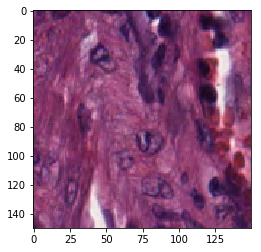

In [0]:
index = 1000
plt.imshow(X_train[index])
print ("y = " + str(y_train[index]) + ", it's a '" + classes[y_train[index-1]] +  "' picture.")


In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 150, 150, 3)
(4000,)
(496, 150, 150, 3)
(496,)
(504, 150, 150, 3)
(504,)


## Data Pre-processing

In [0]:
# Resizing images to 1-D array to be fit into NN
X_train = X_train.reshape(4000, 150, 150, 3)
X_valid = X_valid.reshape(496, 150, 150, 3)
X_test = X_test.reshape(504, 150, 150, 3)

# Converting the data to float type 
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

# Scaling the data
X_train = X_train/255.0
X_valid = X_valid/255.0
X_test = X_test/255.0

num_classes = 8

# Converting the output to categorical variables
y_train = to_categorical(y_train-1,num_classes)
y_valid = to_categorical(y_valid-1,num_classes)
y_test = to_categorical(y_test-1, num_classes)

In [0]:
# Chacking the train, validation and test sets

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(4000, 150, 150, 3)
(4000, 8)
(496, 150, 150, 3)
(496, 8)
(504, 150, 150, 3)
(504, 8)


## Create and Compile the VGG16 Model

In [0]:
# LOAD VGG16
input_tensor = Input(shape=(150,150,3))
model_vgg16_conv = applications.VGG16(weights='imagenet', 
                           include_top=False,
                           input_tensor=input_tensor)
model_vgg16_conv.summary()

W0827 18:36:36.184368 140002072065920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 18:36:36.222248 140002072065920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 18:36:36.229412 140002072065920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 18:36:36.268536 140002072065920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



58892288/58889256 [==============================] - 12s 0us/step


W0827 18:36:48.559922 140002072065920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0827 18:36:48.561178 140002072065920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

Reference link: https://www.analyticsvidhya.com/blog/2017/06/transfer-learning-the-art-of-fine-tuning-a-pre-trained-model/

In [0]:
# Make vgg16 model layers as non trainable
for layer in model_vgg16_conv.layers:
    layer.trainable = False

# Create our own input format
input = Input(shape=(150,150,3),name = 'image_input')   

# Use the generated model 
output_vgg16_conv = model_vgg16_conv(input)

# Add the flatten layer and output layer
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
x = Dense(8, activation='softmax', name='predictions')(x)

# Create our own model
my_model1 = Model(input=input, output=x)
my_model1.summary()
my_model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
W0827 18:36:52.663032 140002072065920 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 150, 150, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 512)               4194816   
_________________________________________________________________
fc2 (Dense)                  (None, 128)               65664     
_________________________________________________________________
predictions (Dense)          (None, 8)                 1032      
Total params: 18,976,200
Trainable params: 4,261,512
Non-trainable params: 14,714,688
________________________________________________________

## Model Without Data Augmentation

In [0]:
callbacks1 = [EarlyStopping(monitor='val_loss', mode='min', patience=4, baseline=0.8),
         ModelCheckpoint(filepath='best_model1.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
batch_size = 32
nb_classes = 8
nb_epoch = 20

# fit the model
history1 = my_model1.fit(X_train, y_train,
           batch_size=batch_size,
           epochs=nb_epoch,
           callbacks=callbacks1,
           validation_data=(X_valid, y_valid))

W0827 18:36:52.824645 140002072065920 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4000 samples, validate on 496 samples
Epoch 1/20
4000/4000 [==============================] - 28s 7ms/step - loss: 0.7544 - acc: 0.7385 - val_loss: 0.4239 - val_acc: 0.8488
Epoch 2/20
4000/4000 [==============================] - 22s 6ms/step - loss: 0.3621 - acc: 0.8768 - val_loss: 0.4330 - val_acc: 0.8387
Epoch 3/20
4000/4000 [==============================] - 22s 6ms/step - loss: 0.2584 - acc: 0.9120 - val_loss: 0.4733 - val_acc: 0.8367
Epoch 4/20
4000/4000 [==============================] - 22s 6ms/step - loss: 0.2062 - acc: 0.9270 - val_loss: 0.3941 - val_acc: 0.8548
Epoch 5/20
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1370 - acc: 0.9535 - val_loss: 0.3769 - val_acc: 0.8589
Epoch 6/20
4000/4000 [==============================] - 22s 6ms/step - loss: 0.1302 - acc: 0.9570 - val_loss: 0.5120 - val_acc: 0.8246
Epoch 7/20
4000/4000 [==============================] - 22s 6ms/step - loss: 0.0943 - acc: 0.9650 - val_loss: 0.5668 - val_acc: 0.8407
Epoch 8/

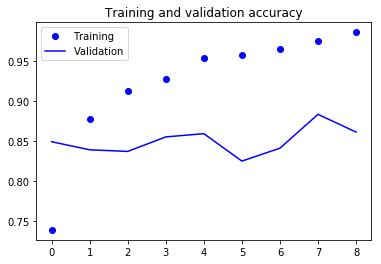

In [0]:
plt.plot(history1.history['acc'], 'bo', label='Training')
plt.plot(history1.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model1 = load_model('best_model1.h5')

In [0]:
score1 = opt_model1.evaluate(X_test,y_test)

504/504 [==============================] - 4s 8ms/step


In [0]:
score1

[0.3181561662682465, 0.8928571428571429]

## Model with Data Augmentation

### Aug1: change in direction, brightness, and color channel

In [0]:
my_model2 = Model(input=input, output=x)
my_model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# datagen1 includes changes in image direction, brightness, and color channel
datagen1 = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, brightness_range=(0.5,1.5), channel_shift_range=100)
datagen1.fit(X_train)

In [0]:
callbacks2 = [EarlyStopping(monitor='val_loss', mode='min', patience=4),
         ModelCheckpoint(filepath='best_model2.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
# Fit the model on the batches generated by datagen.flow
history2 = my_model2.fit_generator(datagen1.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks2,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 23s 181ms/step - loss: 2.8314 - acc: 0.1537 - val_loss: 2.7744 - val_acc: 0.4052
Epoch 2/20
125/125 [==============================] - 22s 173ms/step - loss: 2.1198 - acc: 0.1527 - val_loss: 3.1928 - val_acc: 0.3125
Epoch 3/20
125/125 [==============================] - 22s 173ms/step - loss: 2.0865 - acc: 0.1650 - val_loss: 2.6535 - val_acc: 0.4536
Epoch 4/20
125/125 [==============================] - 22s 174ms/step - loss: 2.0990 - acc: 0.1615 - val_loss: 6.7079 - val_acc: 0.1935
Epoch 5/20
125/125 [==============================] - 22s 173ms/step - loss: 2.0695 - acc: 0.1613 - val_loss: 9.6707 - val_acc: 0.1250
Epoch 6/20
125/125 [==============================] - 22s 173ms/step - loss: 2.0865 - acc: 0.1698 - val_loss: 7.8441 - val_acc: 0.1331
Epoch 7/20
125/125 [==============================] - 22s 173ms/step - loss: 2.0903 - acc: 0.1540 - val_loss: 5.4156 - val_acc: 0.1895


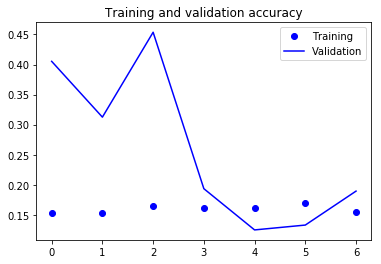

In [0]:
plt.plot(history2.history['acc'], 'bo', label='Training')
plt.plot(history2.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model2 = load_model('best_model2.h5')

In [0]:
score2 = opt_model2.evaluate(X_test,y_test)

504/504 [==============================] - 3s 5ms/step


In [0]:
score2

[2.6095562983481657, 0.4662698412698413]

### Aug2: input standardization across the entire dataset

In [0]:
my_model3 = Model(input=input, output=x)
my_model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# datagen2 includes input standardization across the entire dataset
datagen2 = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
datagen2.fit(X_train)

In [0]:
callbacks3 = [EarlyStopping(monitor='val_loss', mode='min', patience=4),
         ModelCheckpoint(filepath='best_model3.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
# Fit the model on the batches generated by datagen.flow
history3 = my_model3.fit_generator(datagen2.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks3,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 22s 178ms/step - loss: 0.0122 - acc: 0.9978 - val_loss: 1.9107 - val_acc: 0.6734
Epoch 2/20
125/125 [==============================] - 22s 179ms/step - loss: 0.0072 - acc: 0.9980 - val_loss: 1.9019 - val_acc: 0.6915
Epoch 3/20
125/125 [==============================] - 22s 179ms/step - loss: 0.0057 - acc: 0.9990 - val_loss: 1.8879 - val_acc: 0.7097
Epoch 4/20
125/125 [==============================] - 22s 179ms/step - loss: 0.0044 - acc: 0.9993 - val_loss: 1.9746 - val_acc: 0.6915
Epoch 5/20
125/125 [==============================] - 22s 179ms/step - loss: 0.0053 - acc: 0.9990 - val_loss: 1.9582 - val_acc: 0.6996
Epoch 6/20
125/125 [==============================] - 22s 180ms/step - loss: 0.0035 - acc: 0.9995 - val_loss: 1.9900 - val_acc: 0.7016
Epoch 7/20
125/125 [==============================] - 22s 179ms/step - loss: 0.0046 - acc: 0.9993 - val_loss: 2.0062 - val_acc: 0.7077


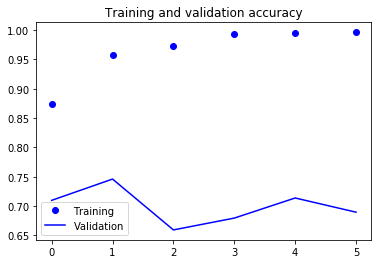

In [0]:
plt.plot(history3.history['acc'], 'bo', label='Training')
plt.plot(history3.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model3 = load_model('best_model3.h5')

In [0]:
score3 = opt_model3.evaluate(X_test,y_test)

504/504 [==============================] - 3s 5ms/step


In [0]:
score3

[0.7647199335079344, 0.7916666666666666]

**Significant overfitting in train set.**

### Aug3: sample-wise input standardization

In [0]:
my_model4 = Model(input=input, output=x)
my_model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# datagen3 includes sample-wise input standardization
datagen3 = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)
datagen3.fit(X_train)

In [0]:
callbacks4 = [EarlyStopping(monitor='val_loss', mode='min', patience=4),
         ModelCheckpoint(filepath='best_model4.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
# Fit the model on the batches generated by datagen.flow
history4 = my_model4.fit_generator(datagen3.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks4,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

Epoch 1/20
  1/125 [..............................] - ETA: 23s - loss: 0.0068 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


125/125 [==============================] - 22s 180ms/step - loss: 0.0882 - acc: 0.9748 - val_loss: 3.3810 - val_acc: 0.5625
Epoch 2/20
125/125 [==============================] - 22s 180ms/step - loss: 0.0287 - acc: 0.9892 - val_loss: 3.3815 - val_acc: 0.5746
Epoch 3/20
125/125 [==============================] - 22s 179ms/step - loss: 0.0076 - acc: 0.9980 - val_loss: 3.3792 - val_acc: 0.5847
Epoch 4/20
125/125 [==============================] - 22s 179ms/step - loss: 0.0284 - acc: 0.9898 - val_loss: 3.5570 - val_acc: 0.5726
Epoch 5/20
125/125 [==============================] - 22s 179ms/step - loss: 0.1001 - acc: 0.9702 - val_loss: 3.9729 - val_acc: 0.5141
Epoch 6/20
125/125 [==============================] - 22s 180ms/step - loss: 0.0229 - acc: 0.9942 - val_loss: 2.2241 - val_acc: 0.6431
Epoch 7/20
125/125 [==============================] - 22s 180ms/step - loss: 0.0036 - acc: 0.9990 - val_loss: 2.9053 - val_acc: 0.6149
Epoch 8/20
125/125 [==============================] - 22s 180ms/st

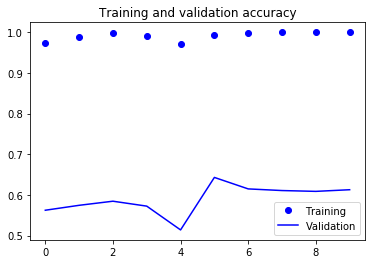

In [0]:
plt.plot(history4.history['acc'], 'bo', label='Training')
plt.plot(history4.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model4 = load_model('best_model4.h5')

In [0]:
score4 = opt_model4.evaluate(X_test,y_test)

504/504 [==============================] - 3s 5ms/step


In [0]:
score4

[0.7647199335079344, 0.7916666666666666]

**Again overfitting in the train set.**

### Aug4: only change in brightness

In [0]:
my_model5 = Model(input=input, output=x)
my_model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# datagen4 only includes changes brightness
datagen4 = ImageDataGenerator(brightness_range=(0.5,1.5))
datagen4.fit(X_train)

In [0]:
callbacks5 = [EarlyStopping(monitor='val_loss', mode='min', patience=4),
         ModelCheckpoint(filepath='best_model5.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
# Fit the model on the batches generated by datagen.flow
history5 = my_model5.fit_generator(datagen4.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks5,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 24s 191ms/step - loss: 2.1263 - acc: 0.8548 - val_loss: 7.0859 - val_acc: 0.4536
Epoch 2/20
125/125 [==============================] - 22s 178ms/step - loss: 1.9306 - acc: 0.8668 - val_loss: 4.1120 - val_acc: 0.5907
Epoch 3/20
125/125 [==============================] - 22s 179ms/step - loss: 1.9626 - acc: 0.8685 - val_loss: 4.7178 - val_acc: 0.5161
Epoch 4/20
125/125 [==============================] - 22s 179ms/step - loss: 1.9562 - acc: 0.8672 - val_loss: 6.3749 - val_acc: 0.4536
Epoch 5/20
125/125 [==============================] - 22s 180ms/step - loss: 1.6255 - acc: 0.8882 - val_loss: 7.0229 - val_acc: 0.3286
Epoch 6/20
125/125 [==============================] - 22s 180ms/step - loss: 1.4750 - acc: 0.8962 - val_loss: 5.9791 - val_acc: 0.4657


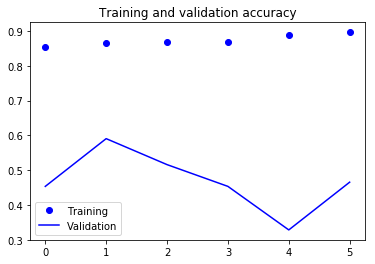

In [0]:
plt.plot(history5.history['acc'], 'bo', label='Training')
plt.plot(history5.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model5 = load_model('best_model5.h5')

In [0]:
score5 = opt_model5.evaluate(X_test,y_test)

504/504 [==============================] - 3s 6ms/step


In [0]:
score5

[4.039113120190681, 0.5753968253968254]

**No obvious overfitting. Possible conclusion: tissue cell brightness plays an important role in classifying different cancer types.**

### Aug5: only change in image direction

In [0]:
my_model6 = Model(input=input, output=x)
my_model6.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# datagen5 only includes changes direction
datagen5 = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
datagen5.fit(X_train)

In [0]:
callbacks6 = [EarlyStopping(monitor='val_loss', mode='min', patience=4),
         ModelCheckpoint(filepath='best_model6.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
# Fit the model on the batches generated by datagen.flow
history6 = my_model6.fit_generator(datagen5.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks6,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 23s 187ms/step - loss: 1.0028 - acc: 0.8050 - val_loss: 0.4176 - val_acc: 0.8448
Epoch 2/20
125/125 [==============================] - 22s 179ms/step - loss: 0.3528 - acc: 0.8732 - val_loss: 0.4051 - val_acc: 0.8649
Epoch 3/20
125/125 [==============================] - 22s 179ms/step - loss: 0.3120 - acc: 0.8950 - val_loss: 0.4109 - val_acc: 0.8468
Epoch 4/20
125/125 [==============================] - 22s 179ms/step - loss: 0.2851 - acc: 0.8930 - val_loss: 0.3612 - val_acc: 0.8690
Epoch 5/20
125/125 [==============================] - 22s 179ms/step - loss: 0.2622 - acc: 0.9070 - val_loss: 0.3594 - val_acc: 0.8649
Epoch 6/20
125/125 [==============================] - 22s 179ms/step - loss: 0.2447 - acc: 0.9123 - val_loss: 0.3446 - val_acc: 0.8710
Epoch 7/20
125/125 [==============================] - 22s 180ms/step - loss: 0.2257 - acc: 0.9190 - val_loss: 0.3693 - val_acc: 0.8750
Epoch 8/20
125/125 [==============================] - 2

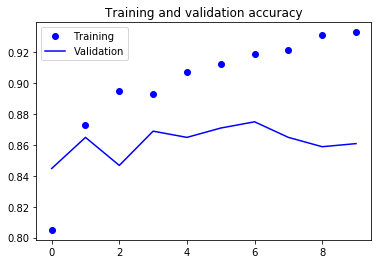

In [0]:
plt.plot(history6.history['acc'], 'bo', label='Training')
plt.plot(history6.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model6 = load_model('best_model6.h5')

In [0]:
score6 = opt_model6.evaluate(X_test,y_test)

504/504 [==============================] - 3s 6ms/step


In [0]:
score6

[0.28115985226181767, 0.8988095238095238]

**A little bit improvement compared to the model w/o data augmentation (0.8929).**

### Aug6: only height and width shift

In [0]:
my_model7 = Model(input=input, output=x)
my_model7.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# datagen6 only includes height and width shift
datagen6 = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)
datagen6.fit(X_train)

In [0]:
callbacks7 = [EarlyStopping(monitor='val_loss', mode='min', patience=4),
         ModelCheckpoint(filepath='best_model7.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
# Fit the model on the batches generated by datagen.flow
history7 = my_model7.fit_generator(datagen6.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks7,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 25s 203ms/step - loss: 0.1949 - acc: 0.9275 - val_loss: 0.4875 - val_acc: 0.8589
Epoch 2/20
125/125 [==============================] - 22s 180ms/step - loss: 0.1890 - acc: 0.9365 - val_loss: 0.4062 - val_acc: 0.8629
Epoch 3/20
125/125 [==============================] - 22s 180ms/step - loss: 0.1463 - acc: 0.9493 - val_loss: 0.4418 - val_acc: 0.8690
Epoch 4/20
125/125 [==============================] - 23s 180ms/step - loss: 0.1464 - acc: 0.9480 - val_loss: 0.4691 - val_acc: 0.8609
Epoch 5/20
125/125 [==============================] - 22s 180ms/step - loss: 0.1443 - acc: 0.9537 - val_loss: 0.3993 - val_acc: 0.8609
Epoch 6/20
125/125 [==============================] - 22s 179ms/step - loss: 0.1095 - acc: 0.9633 - val_loss: 0.4422 - val_acc: 0.8629
Epoch 7/20
125/125 [==============================] - 22s 180ms/step - loss: 0.1147 - acc: 0.9600 - val_loss: 0.5156 - val_acc: 0.8609
Epoch 8/20
125/125 [==============================] - 2

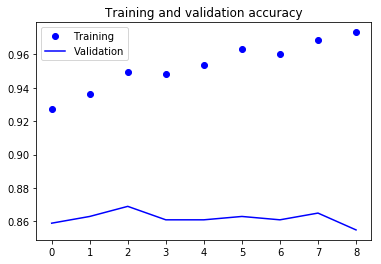

In [0]:
plt.plot(history7.history['acc'], 'bo', label='Training')
plt.plot(history7.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model7 = load_model('best_model7.h5')

In [0]:
score7 = opt_model7.evaluate(X_test,y_test)

504/504 [==============================] - 3s 6ms/step


In [0]:
score7

[0.3375860435503816, 0.9107142857142857]

**Great accuracy!**

### Aug7: flips & shifts (aug5 + aug6)

In [0]:
my_model8 = Model(input=input, output=x)
my_model8.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  """Entry point for launching an IPython kernel.


In [0]:
# datagen7 includes both flips and shifts
datagen7 = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, vertical_flip=True)
datagen7.fit(X_train)

In [0]:
callbacks8 = [EarlyStopping(monitor='val_loss', mode='min', patience=4),
         ModelCheckpoint(filepath='best_model8.h5', monitor='val_loss', mode='min', save_best_only=True)]

In [0]:
# Fit the model on the batches generated by datagen.flow
history8 = my_model8.fit_generator(datagen7.flow(X_train, y_train, batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        validation_data=(X_valid, y_valid),
                        callbacks=callbacks8,
                        epochs=nb_epoch, verbose=1, max_q_size=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=125, validation_data=(array([[[..., callbacks=[<keras.ca..., epochs=20, verbose=1, max_queue_size=100)`
  """


Epoch 1/20
125/125 [==============================] - 28s 220ms/step - loss: 0.3037 - acc: 0.8995 - val_loss: 0.3542 - val_acc: 0.8710
Epoch 2/20
125/125 [==============================] - 24s 193ms/step - loss: 0.2425 - acc: 0.9110 - val_loss: 0.4505 - val_acc: 0.8609
Epoch 3/20
125/125 [==============================] - 25s 203ms/step - loss: 0.2284 - acc: 0.9197 - val_loss: 0.4588 - val_acc: 0.8548
Epoch 4/20
125/125 [==============================] - 25s 198ms/step - loss: 0.2206 - acc: 0.9240 - val_loss: 0.3245 - val_acc: 0.8871
Epoch 5/20
125/125 [==============================] - 25s 203ms/step - loss: 0.2053 - acc: 0.9317 - val_loss: 0.3281 - val_acc: 0.8690
Epoch 6/20
125/125 [==============================] - 24s 194ms/step - loss: 0.2042 - acc: 0.9218 - val_loss: 0.3020 - val_acc: 0.8891
Epoch 7/20
125/125 [==============================] - 25s 202ms/step - loss: 0.2033 - acc: 0.9310 - val_loss: 0.3486 - val_acc: 0.8770
Epoch 8/20
125/125 [==============================] - 2

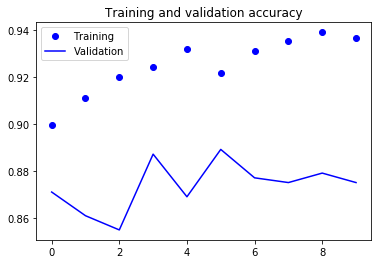

In [0]:
plt.plot(history8.history['acc'], 'bo', label='Training')
plt.plot(history8.history['val_acc'], 'b', label='Validation')

plt.title('Training and validation accuracy')
plt.legend()

In [0]:
opt_model8 = load_model('best_model8.h5')

In [0]:
score8 = opt_model8.evaluate(X_test,y_test)

504/504 [==============================] - 3s 6ms/step


In [0]:
score8

[0.3048779737381708, 0.9047619047619048]

**This model also shows improvement. But not as good as shifts only. Ranking by model performance: aug6 > aug7 > aug5.**